In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 21 09:57:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 130 µs (started: 2022-02-21 09:57:52 +00:00)


In [3]:
!pip install --quiet optuna

     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 13.0 MB/s 
     |████████████████████████████████| 210 kB 83.3 MB/s 
     |████████████████████████████████| 75 kB 5.9 MB/s 
     |████████████████████████████████| 149 kB 70.0 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
     |████████████████████████████████| 113 kB 76.9 MB/s 
time: 5.64 s (started: 2022-02-21 09:57:52 +00:00)


In [4]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params
from keras.preprocessing.image import ImageDataGenerator

from xgboost import XGBClassifier
import optuna # hyeperparam optimization 

time: 3.47 s (started: 2022-02-21 09:57:57 +00:00)


# Variables

## Paths

In [5]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 
stacking_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Stacking/'
trained_model_dirs = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Stacking/'

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220221_09H58/
time: 517 ms (started: 2022-02-21 09:58:01 +00:00)


## Other

In [6]:
# seed
random_seed = 42


# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = None  # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)

# DL Models 
redo_indivdual_predictions = True
batch_size = 32 # predictions only 

# Optuna + XGBOOST
tree_method = 'gpu_hist' if int(os.environ["COLAB_GPU"]) > 0 else 'hist'
n_trials = 50 # number optuna bayesian opt 
n_estimators = 500 # nombre d'arbre xgboosting MAX qui sera limité par l'early stopping
early_stopping_rounds = 25  # window of the number of epochs over which no improvement is observed

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
family_number = 3 if debug else family_number 


time: 6.86 ms (started: 2022-02-21 09:58:01 +00:00)


# Load & filter data

## Unzip images

In [7]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/618224.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/619311.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/619904.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/620199.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/620814.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/621320.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/622509.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/624754.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/627015.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/627187.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/629081.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune

In [8]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 2.02 ms (started: 2022-02-21 10:00:09 +00:00)


## File_path df

In [9]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 2.85 s (started: 2022-02-21 10:00:09 +00:00)


In [10]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 3.2 ms (started: 2022-02-21 10:00:12 +00:00)


In [11]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 250 ms (started: 2022-02-21 10:00:12 +00:00)


In [12]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 150 ms (started: 2022-02-21 10:00:12 +00:00)


In [13]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 46.3 ms (started: 2022-02-21 10:00:12 +00:00)


In [14]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 39.1 ms (started: 2022-02-21 10:00:12 +00:00)


In [15]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 63.4 ms (started: 2022-02-21 10:00:12 +00:00)


In [16]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 21.2 ms (started: 2022-02-21 10:00:12 +00:00)


In [17]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 30.2 ms (started: 2022-02-21 10:00:12 +00:00)


In [18]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

time: 1.81 ms (started: 2022-02-21 10:00:12 +00:00)


In [19]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 8.36 ms (started: 2022-02-21 10:00:12 +00:00)


In [20]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
5,/content/RAW DATA/IMAGES/2006/Agaricus/682.jpg,Agaricaceae,0
6,/content/RAW DATA/IMAGES/2006/Agaricus/685.jpg,Agaricaceae,0
7,/content/RAW DATA/IMAGES/2006/Agaricus albolut...,Agaricaceae,0
8,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0
9,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0


time: 55.4 ms (started: 2022-02-21 10:00:12 +00:00)


In [21]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.19 ms (started: 2022-02-21 10:00:12 +00:00)


In [22]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 35787


,label,gbif_info.family,size
0,0,Agaricaceae,5254
1,1,Strophariaceae,4494
2,2,Amanitaceae,4769
3,3,Boletaceae,6060
4,4,Tricholomataceae,4967
5,5,Cortinariaceae,4124
6,6,Russulaceae,6119


time: 29.7 ms (started: 2022-02-21 10:00:12 +00:00)


In [23]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

time: 3.57 ms (started: 2022-02-21 10:00:12 +00:00)


## Train/test split

In [24]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(22903, 3) (5726, 3) (7158, 3)
time: 67.2 ms (started: 2022-02-21 10:00:13 +00:00)


In [25]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 32.1 ms (started: 2022-02-21 10:00:13 +00:00)


### Plot few images

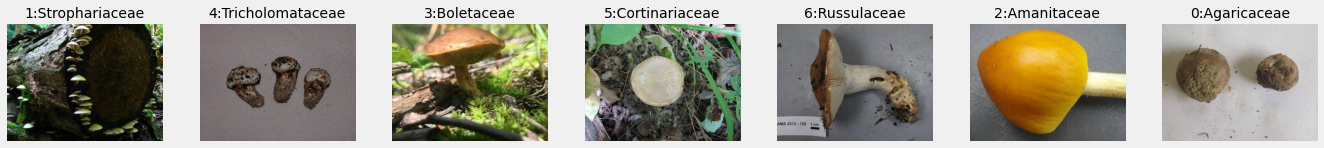

time: 501 ms (started: 2022-02-21 10:00:13 +00:00)


In [26]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

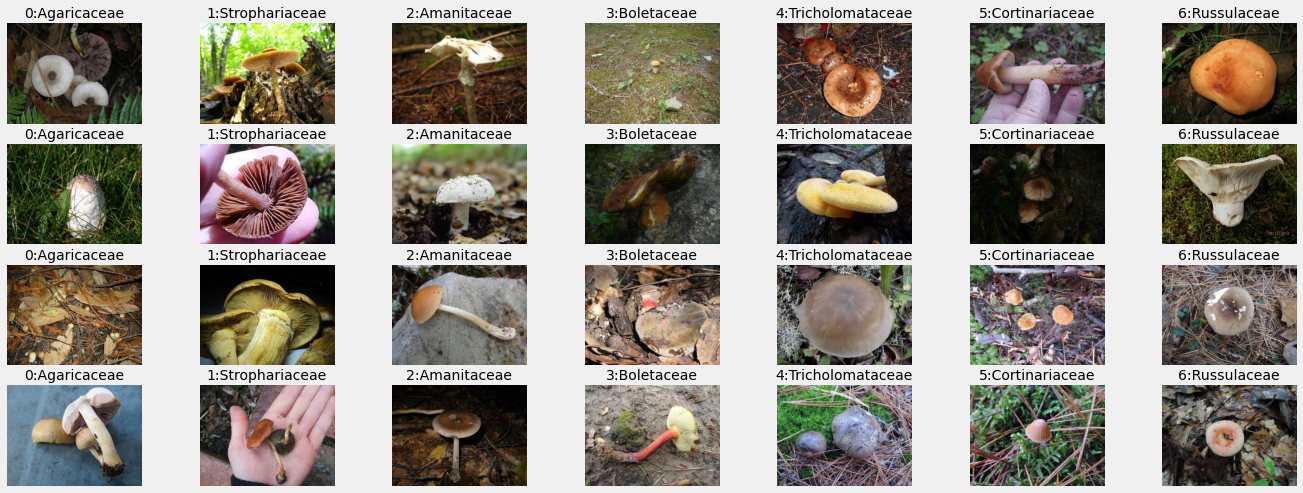

time: 1.46 s (started: 2022-02-21 10:00:13 +00:00)


In [27]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Fonctions

In [28]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 25.4 ms (started: 2022-02-21 10:00:15 +00:00)


In [29]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 47 ms (started: 2022-02-21 10:00:15 +00:00)


In [30]:
# https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
def stack_predictions(predict_dict):
  # Train 
  stackX = None 
  for model, prediction in predict_dict.items():
    # stack predictions into [rows, probabilities, models]
      if stackX is None:
        stackX = prediction
      else:
        stackX = np.dstack((stackX, prediction)) # ()
  # flatten predictions to [rows, probabilities x models ]
  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
  print(stackX.shape) 
  return stackX 

time: 3.85 ms (started: 2022-02-21 10:00:15 +00:00)


In [31]:
#cf https://stackoverflow.com/questions/62244457/progress-of-model-predict-in-tensorflow
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

time: 17.6 ms (started: 2022-02-21 10:00:15 +00:00)


# Load individual models

In [32]:
if redo_indivdual_predictions:
  # get all zip files 
  os.chdir(trained_model_dirs)
  model_zips = glob.glob('*.zip')
  print(model_zips)

['resnet50_final_model.zip', 'MobileNetV3Large_final_model.zip', 'EFB1_final_model.zip', 'VGG16_final_model.zip', 'VGG19_final_model.zip']
time: 9.89 ms (started: 2022-02-21 10:00:15 +00:00)


In [33]:
if redo_indivdual_predictions:
  #unzip models 
  for zip_file in model_zips:
    zip_path = trained_model_dirs + zip_file
    destination_dir = "/content/" + zip_file.replace(".zip","")
    if os.path.exists(destination_dir)== False :
      !unzip "$zip_path"  -d "$destination_dir"
    

Archive:  /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Stacking/resnet50_final_model.zip
   creating: /content/resnet50_final_model/resnet50_final_model/
   creating: /content/resnet50_final_model/resnet50_final_model/assets/
  inflating: /content/resnet50_final_model/resnet50_final_model/assets/desktop.ini  
  inflating: /content/resnet50_final_model/resnet50_final_model/desktop.ini  
  inflating: /content/resnet50_final_model/resnet50_final_model/keras_metadata.pb  
  inflating: /content/resnet50_final_model/resnet50_final_model/saved_model.pb  
   creating: /content/resnet50_final_model/resnet50_final_model/variables/
  inflating: /content/resnet50_final_model/resnet50_final_model/variables/desktop.ini  
  inflating: /content/resnet50_final_model/resnet50_final_model/variables/variables.data-00000-of-00001  
  inflating: /content/resnet50_final_model/resnet50_final_model/variables/variables.index  
Archive:  /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/St

In [34]:
models_dirs = [name for name in os.listdir("/content") if 'final_model' in name ]
models_dirs

['VGG19_final_model',
 'EFB1_final_model',
 'MobileNetV3Large_final_model',
 'resnet50_final_model',
 'VGG16_final_model']

time: 4.72 ms (started: 2022-02-21 10:00:39 +00:00)


## Individual predictions

In [35]:
# Load data 
# train sur df_train_ car on veut pas de biais
train_data_generator = ImageDataGenerator(
                                          # rotation_range=0.1,horizontal_flip= True,vertical_flip= True
                                          ) 
train_generator_ = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                          x_col = "drive_file_path",y_col="label",
                                                          shuffle = False, # to match label order  
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
# val
val_data_generator = ImageDataGenerator() 
val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                          shuffle = False, # to match label order  
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
# true label
y_train_class_= df_train_['label'].values.astype(int)
y_valid_class= df_val_['label'].values.astype(int)
y_test_class= df_test['label'].values.astype(int)

Found 22903 validated image filenames belonging to 7 classes.
Found 5726 validated image filenames belonging to 7 classes.
Found 7158 validated image filenames belonging to 7 classes.
time: 341 ms (started: 2022-02-21 10:00:39 +00:00)


In [36]:
# for dir_name in content_dirs:
#   print(dir_name)
#   name = dir_name.split("_")[0]
#   subdir_name = [name for name in os.listdir("/content/" +dir_name )][0] # pas toujours le meme nom 
#   models[name] = keras.models.load_model('/content/'+ dir_name + '/' + subdir_name)

time: 1.23 ms (started: 2022-02-21 10:00:40 +00:00)


**************************************************Predicting TRAIN with model VGG19**************************************************


  1%|          | 5/715 [00:12<02:55,  4.05it/s]

100%|██████████| 715/715 [03:20<00:00,  3.56it/s]


**************************************************Predicting VALID with model VGG19**************************************************


  3%|▎         | 5/178 [00:01<00:46,  3.73it/s]

100%|██████████| 178/178 [00:50<00:00,  3.51it/s]


**************************************************Predicting TEST with model VGG19**************************************************


  2%|▏         | 5/223 [00:01<00:58,  3.74it/s]

100%|██████████| 223/223 [01:02<00:00,  3.59it/s]


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1051
           1       0.59      0.66      0.62       899
           2       0.81      0.72      0.76       954
           3       0.80      0.80      0.80      1212
           4       0.53      0.62      0.57       993
           5       0.57      0.51      0.54       825
           6       0.71      0.71      0.71      1224

    accuracy                           0.68      7158
   macro avg       0.68      0.67      0.67      7158
weighted avg       0.68      0.68      0.68      7158



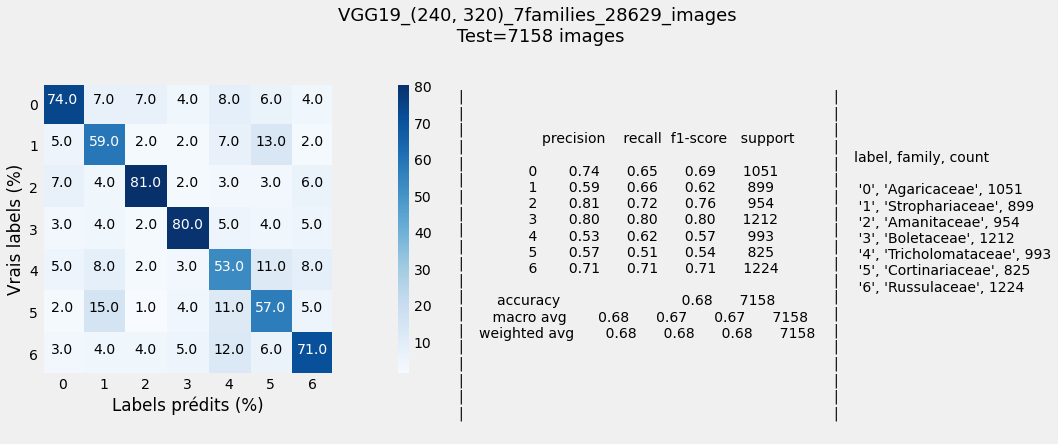

**************************************************Predicting TRAIN with model EFB1**************************************************


  1%|          | 5/715 [00:04<01:26,  8.25it/s]

100%|██████████| 715/715 [01:33<00:00,  7.68it/s]


**************************************************Predicting VALID with model EFB1**************************************************


  3%|▎         | 5/178 [00:00<00:21,  7.94it/s]

100%|██████████| 178/178 [00:23<00:00,  7.63it/s]


**************************************************Predicting TEST with model EFB1**************************************************


  2%|▏         | 5/223 [00:00<00:26,  8.13it/s]

100%|██████████| 223/223 [00:28<00:00,  7.74it/s]


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1051
           1       0.70      0.75      0.72       899
           2       0.85      0.82      0.84       954
           3       0.86      0.89      0.87      1212
           4       0.70      0.66      0.68       993
           5       0.66      0.72      0.69       825
           6       0.83      0.82      0.82      1224

    accuracy                           0.78      7158
   macro avg       0.77      0.77      0.77      7158
weighted avg       0.78      0.78      0.78      7158



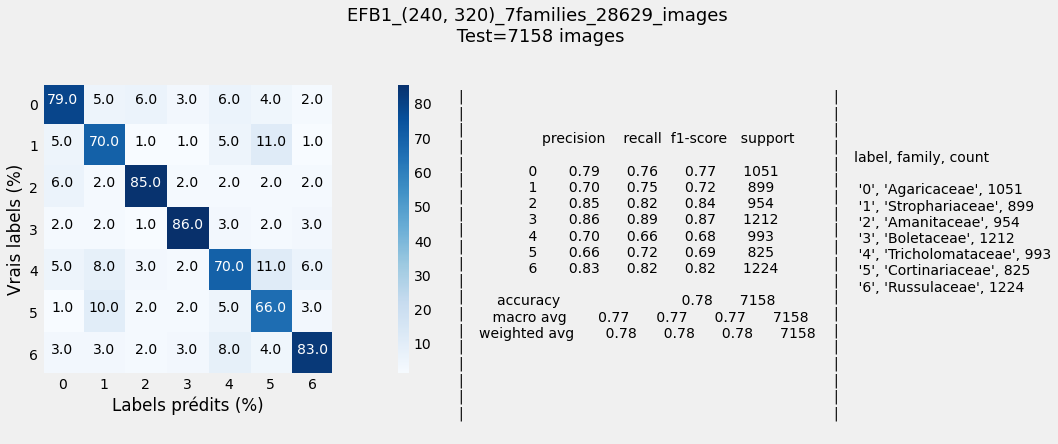

**************************************************Predicting TRAIN with model MobileNetV3Large**************************************************


  1%|          | 4/715 [00:01<00:49, 14.25it/s]

100%|██████████| 715/715 [00:55<00:00, 12.86it/s]


**************************************************Predicting VALID with model MobileNetV3Large**************************************************


  2%|▏         | 4/178 [00:00<00:12, 13.94it/s]

100%|██████████| 178/178 [00:13<00:00, 13.23it/s]


**************************************************Predicting TEST with model MobileNetV3Large**************************************************


  2%|▏         | 4/223 [00:00<00:15, 14.16it/s]

100%|██████████| 223/223 [00:16<00:00, 13.46it/s]


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1051
           1       0.72      0.72      0.72       899
           2       0.85      0.84      0.84       954
           3       0.85      0.89      0.87      1212
           4       0.67      0.70      0.69       993
           5       0.72      0.68      0.70       825
           6       0.80      0.80      0.80      1224

    accuracy                           0.77      7158
   macro avg       0.77      0.77      0.77      7158
weighted avg       0.77      0.77      0.77      7158



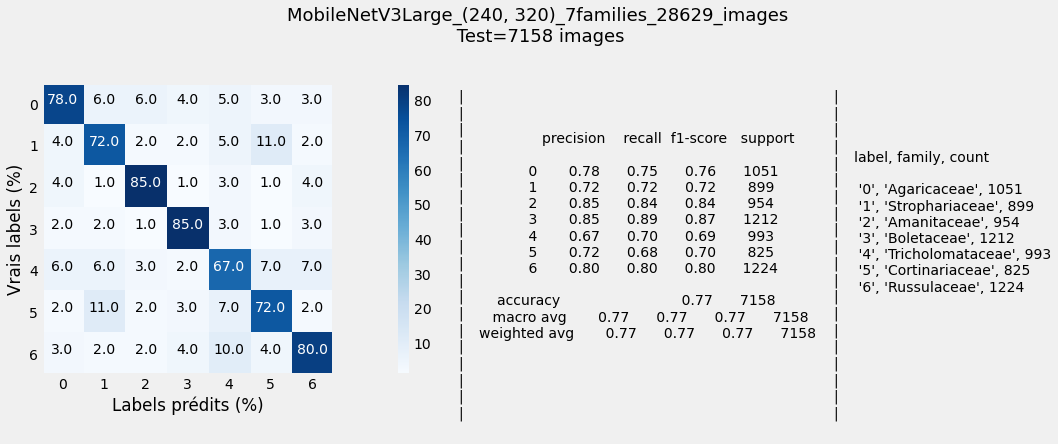

**************************************************Predicting TRAIN with model resnet50**************************************************


  1%|          | 5/715 [00:04<01:49,  6.46it/s]

100%|██████████| 715/715 [01:55<00:00,  6.17it/s]


**************************************************Predicting VALID with model resnet50**************************************************


  3%|▎         | 5/178 [00:01<00:27,  6.32it/s]

100%|██████████| 178/178 [00:29<00:00,  6.09it/s]


**************************************************Predicting TEST with model resnet50**************************************************


  2%|▏         | 5/223 [00:01<00:34,  6.34it/s]

100%|██████████| 223/223 [00:35<00:00,  6.21it/s]


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1051
           1       0.67      0.65      0.66       899
           2       0.80      0.80      0.80       954
           3       0.86      0.83      0.85      1212
           4       0.60      0.63      0.62       993
           5       0.63      0.62      0.62       825
           6       0.76      0.76      0.76      1224

    accuracy                           0.73      7158
   macro avg       0.72      0.72      0.72      7158
weighted avg       0.73      0.73      0.73      7158



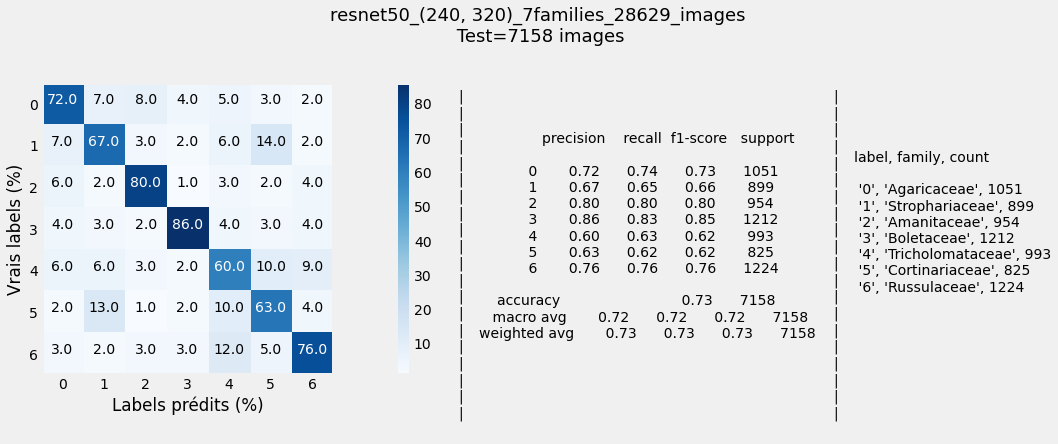

**************************************************Predicting TRAIN with model VGG16**************************************************


  1%|          | 5/715 [00:01<02:38,  4.47it/s]

100%|██████████| 715/715 [02:40<00:00,  4.44it/s]


**************************************************Predicting VALID with model VGG16**************************************************


  3%|▎         | 5/178 [00:01<00:39,  4.40it/s]

100%|██████████| 178/178 [00:40<00:00,  4.42it/s]


**************************************************Predicting TEST with model VGG16**************************************************


  2%|▏         | 5/223 [00:01<00:49,  4.39it/s]

100%|██████████| 223/223 [00:50<00:00,  4.44it/s]


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1051
           1       0.66      0.65      0.65       899
           2       0.80      0.77      0.78       954
           3       0.81      0.83      0.82      1212
           4       0.59      0.66      0.62       993
           5       0.62      0.59      0.60       825
           6       0.76      0.71      0.73      1224

    accuracy                           0.71      7158
   macro avg       0.70      0.70      0.70      7158
weighted avg       0.71      0.71      0.71      7158



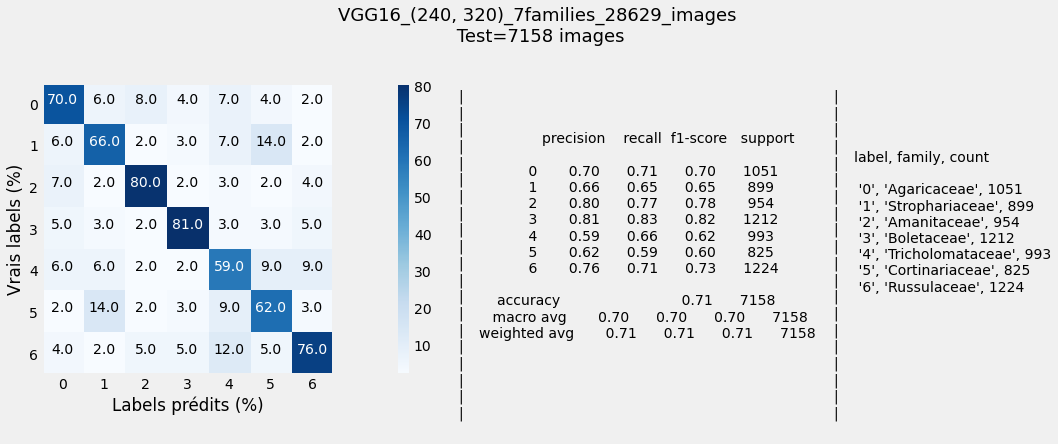

time: 17min 23s (started: 2022-02-21 10:00:40 +00:00)


In [37]:
# predict 
predictions_test = {}
predictions_val = {}
predictions_train_ = {}
for model_dir in models_dirs:
  if redo_indivdual_predictions:
    # clear all models currently loaded in memory
    K.clear_session() 
    #load model 
    name = model_dir.split("_")[0]
    subdir_name = [name for name in os.listdir("/content/" +model_dir )][0] # pas toujours le meme nom
    model= keras.models.load_model('/content/'+ model_dir + '/' + subdir_name)
    # defnine pathinfos 
    pathinfos = name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
    print("*"*50 + 'Predicting TRAIN with model ' + name +  '*'*50)
    y_prob_train_ = model.predict(train_generator_,len(df_train_)//batch_size,callbacks=[TQDMPredictCallback()]) 
    predictions_train_[name] = y_prob_train_
    print("*"*50 + 'Predicting VALID with model ' + name +  '*'*50)
    y_prob_val = model.predict(val_generator,len(df_val_)//batch_size,callbacks=[TQDMPredictCallback()]) 
    predictions_val[name] = y_prob_val
    print("*"*50 + 'Predicting TEST with model ' + name +  '*'*50)
    y_prob_test = model.predict(test_generator,len(df_test)//batch_size,callbacks=[TQDMPredictCallback()])
    predictions_test[name] = y_prob_test
    # save predictions
    np.save( stacking_dir + name + '_y_prob_train_', y_prob_train_)
    np.save( stacking_dir + name +'_y_prob_val', y_prob_val)
    np.save( stacking_dir + name + '_y_prob_test', y_prob_test)
    # predict classes 
    test_pred_class = np.argmax(y_prob_test , axis=1)
    print("*"*50 + 'TEST set classification report' + '*'*50)
    # report 
    print(metrics.classification_report(y_test_class, test_pred_class))
    # save report
    report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
    report = pd.DataFrame(report).transpose()
    report_path = export_dir + pathinfos  + '_classification report.csv'
    report.to_csv(report_path)
    # conf matrix 
    classes = df['gbif_info.family'].nunique()  # classes
    # label and count for legend 
    unique, counts = np.unique(y_test_class, return_counts=True)
    test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
    test_dict_label = dict_label_df.merge(test_dict_label,on='label')
    test_dict_label = test_dict_label.drop(['size'], axis=1)
    # plot 
    conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
    display(conf_matrix_fig)
    # save fig 
    conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
    del model
    gc.collect()
    K.clear_session()
  else: 
    # load images from folder
    print("*"*50 + 'TEST set classification report' + '*'*50)
    name = model_dir.split("_")[0]
    jpeg_files = glob.glob(stacking_dir + '/*.jpeg')
    conf_mat = [jpegfile for jpegfile  in jpeg_files if name in jpegfile and 'conf_matrix' in jpegfile][0]
    plt.figure(figsize=(20,10))
    im = io.imread(conf_mat)
    plt.axis('off')
    plt.imshow(im);

# Stacking

## Stack predictions

* https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [38]:
if redo_indivdual_predictions:
  stackX_train_ = stack_predictions(predictions_train_)
  stackX_val = stack_predictions(predictions_val)
  stackX_test = stack_predictions(predictions_test)
  # save predictions
  np.save( stacking_dir + 'stackX_train_', stackX_train_)
  np.save( stacking_dir + 'stackX_val', stackX_val)
  np.save( stacking_dir + 'stackX_test', stackX_test)

(22903, 35)
(5726, 35)
(7158, 35)
time: 1.68 s (started: 2022-02-21 10:18:03 +00:00)


In [39]:
if redo_indivdual_predictions:
  #quick check 
  from sklearn.svm import SVC
  ML_mod = SVC(C=1)
  ML_mod.fit(stackX_train_, y_train_class_ )
  pred_ = ML_mod.predict(stackX_test).astype(int)
  print(metrics.classification_report(y_test_class, pred_ ))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1051
           1       0.74      0.75      0.74       899
           2       0.88      0.85      0.86       954
           3       0.87      0.91      0.89      1212
           4       0.68      0.72      0.70       993
           5       0.75      0.67      0.71       825
           6       0.82      0.84      0.83      1224

    accuracy                           0.80      7158
   macro avg       0.79      0.79      0.79      7158
weighted avg       0.80      0.80      0.80      7158

time: 364 ms (started: 2022-02-21 10:18:05 +00:00)


## Hyperparam optimisation

In [40]:
if not redo_indivdual_predictions:
  # load predictions
  stackX_train_ = np.load(stacking_dir + 'stackX_train_.npy')
  stackX_val = np.load(stacking_dir + 'stackX_val.npy')
  stackX_test = np.load(stacking_dir + 'stackX_test.npy')

time: 1.91 ms (started: 2022-02-21 10:18:05 +00:00)


In [41]:
def objective(trial):
  print('*'*50 + 'Trial' + str(trial.number) + '/' + str(n_trials) + ' started' + '*'*50)
   # trial param  
  params = {
      # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
      'tree_method':tree_method, 
        # metric 
      "objective": "multi:softmax",
      # "eval_metric": "mlogloss",
      "num_class":7,
      # other 
      # "verbosity": 0,  # 0 (silent) - 3 (debug)
      "n_estimators": n_estimators, #  NOMBRE D'ARBRE MAX sera ajusté par early stopping 
      "max_depth": trial.suggest_int("max_depth", 5, 10), # 2, 25
      "learning_rate": trial.suggest_loguniform("learning_rate", 0.0005, 0.01),
      "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
      "subsample": trial.suggest_loguniform("subsample", 0.1, 0.8), #0.4, 0.8
      "alpha": trial.suggest_loguniform("alpha", 1, 100.0), #  0.01, 10.0
      "lambda": trial.suggest_loguniform("lambda", 1e-9, 10), #1e-8, 10.0
      "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0), #  1e-8, 10.0
      "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 100),
      "seed": random_seed,
      "n_jobs": -1,
  }
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  print(text)
  # ML model 
  xgb_model= XGBClassifier(**params) # Add a callback for pruning cf optuna 
  
  # Add a callback for pruning cf optuna 
  pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-mlogloss") # pruning sur le set d'evaluation
  # ML model fit 
  xgb_model.fit(
                stackX_train_, y_train_class_ ,
                eval_set=[(stackX_train_,y_train_class_ ),(stackX_val, y_valid_class)],
                eval_metric="mlogloss",
                verbose=False,
                 callbacks=[pruning_callback],
                early_stopping_rounds=early_stopping_rounds, # DEF EARLY STOPPING 
                )
   # recupere le nombre de rounds pour future train avec le bon nombre via early stopping et pas celui donné par defaut
  n_estimators_early_stop = len(xgb_model.evals_result()['validation_1']['mlogloss']) # https://github.com/optuna/optuna/issues/1169 & https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
  trial.set_user_attr('n_estimators', n_estimators_early_stop) # <=> epoch 
  print('n_estimators_early_stop = {}'.format(n_estimators_early_stop))
  # get resutlts 
  results = xgb_model.evals_result()
  val_loss = results['validation_1']['mlogloss'][-1]
  # predict on train et validation set 
  train_score = xgb_model.score(stackX_train_,y_train_class_ )
  val_score = xgb_model.score(stackX_val,y_valid_class)
  print('train/val acc={}/{}'.format(train_score,val_score))
  #add to df for later 
  trial.set_user_attr('train score',train_score) # accuracy on valid 
  trial.set_user_attr('valid score',val_score) # accuracy on valid 

  
  return val_loss # a voir si on prend pas l'accuracy plus tard 

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
                            ) 
study.optimize(objective,n_trials=n_trials,callbacks= [lambda study, trial: gc.collect()])

[I 2022-02-21 10:18:05,678] A new study created in memory with name: no-name-a3abbe51-1164-4b97-a222-719a56398630


**************************************************Trial0/50 started**************************************************
trial 0:{'max_depth': 9, 'learning_rate': 0.0005432864059267236, 'colsample_bytree': 0.24050777413414753, 'subsample': 0.34006321069837625, 'alpha': 7.657939468641652, 'lambda': 1.8092828086290565e-06, 'gamma': 5.6087240697407914e-06, 'min_child_weight': 1.138446657471208}


[I 2022-02-21 10:18:22,772] Trial 0 finished with value: 1.517218 and parameters: {'max_depth': 9, 'learning_rate': 0.0005432864059267236, 'colsample_bytree': 0.24050777413414753, 'subsample': 0.34006321069837625, 'alpha': 7.657939468641652, 'lambda': 1.8092828086290565e-06, 'gamma': 5.6087240697407914e-06, 'min_child_weight': 1.138446657471208}. Best is trial 0 with value: 1.517218.


n_estimators_early_stop = 500
train/val acc=0.9996943631838624/0.7885085574572127
**************************************************Trial1/50 started**************************************************
trial 1:{'max_depth': 7, 'learning_rate': 0.004328995798899469, 'colsample_bytree': 0.24276915655369613, 'subsample': 0.21228061813554563, 'alpha': 3.9384516526783107, 'lambda': 0.0028245571639002615, 'gamma': 0.0004348995345553407, 'min_child_weight': 1.3177520105003468}


[I 2022-02-21 10:18:37,269] Trial 1 finished with value: 0.743703 and parameters: {'max_depth': 7, 'learning_rate': 0.004328995798899469, 'colsample_bytree': 0.24276915655369613, 'subsample': 0.21228061813554563, 'alpha': 3.9384516526783107, 'lambda': 0.0028245571639002615, 'gamma': 0.0004348995345553407, 'min_child_weight': 1.3177520105003468}. Best is trial 1 with value: 0.743703.


n_estimators_early_stop = 500
train/val acc=0.999650700781557/0.7893817673768774
**************************************************Trial2/50 started**************************************************
trial 2:{'max_depth': 8, 'learning_rate': 0.003031843835431562, 'colsample_bytree': 0.5443992317980698, 'subsample': 0.14368169399126773, 'alpha': 5.780761958228705, 'lambda': 6.701199874740439e-07, 'gamma': 0.0393100301872978, 'min_child_weight': 2.8959593912671218}


[I 2022-02-21 10:18:37,824] Trial 2 pruned. Trial was pruned at iteration 1.


**************************************************Trial3/50 started**************************************************
trial 3:{'max_depth': 9, 'learning_rate': 0.0016030771616749751, 'colsample_bytree': 0.28254652650871165, 'subsample': 0.2779534792194414, 'alpha': 49.117201005455456, 'lambda': 1.1145292819445826e-08, 'gamma': 2.241952588693891, 'min_child_weight': 4.665812049522052}


[I 2022-02-21 10:18:52,484] Trial 3 finished with value: 1.091226 and parameters: {'max_depth': 9, 'learning_rate': 0.0016030771616749751, 'colsample_bytree': 0.28254652650871165, 'subsample': 0.2779534792194414, 'alpha': 49.117201005455456, 'lambda': 1.1145292819445826e-08, 'gamma': 2.241952588693891, 'min_child_weight': 4.665812049522052}. Best is trial 1 with value: 0.743703.


n_estimators_early_stop = 500
train/val acc=0.9996070383792516/0.793049249039469
**************************************************Trial4/50 started**************************************************
trial 4:{'max_depth': 9, 'learning_rate': 0.001154868613898826, 'colsample_bytree': 0.3193702184807117, 'subsample': 0.15284589348975228, 'alpha': 1.9331085808103206, 'lambda': 0.014731634716879624, 'gamma': 2.2765007336932034e-07, 'min_child_weight': 1.225271574594833}


[I 2022-02-21 10:19:06,696] Trial 4 finished with value: 1.221748 and parameters: {'max_depth': 9, 'learning_rate': 0.001154868613898826, 'colsample_bytree': 0.3193702184807117, 'subsample': 0.15284589348975228, 'alpha': 1.9331085808103206, 'lambda': 0.014731634716879624, 'gamma': 2.2765007336932034e-07, 'min_child_weight': 1.225271574594833}. Best is trial 1 with value: 0.743703.


n_estimators_early_stop = 500
train/val acc=0.9997380255861678/0.7916521131680055
**************************************************Trial5/50 started**************************************************
trial 5:{'max_depth': 7, 'learning_rate': 0.0008175781768511903, 'colsample_bytree': 0.5857081113265203, 'subsample': 0.1994473715609044, 'alpha': 10.153367675933968, 'lambda': 7.540665050877323e-07, 'gamma': 0.3786992554829961, 'min_child_weight': 1.7901021150527194}


[I 2022-02-21 10:19:07,268] Trial 5 pruned. Trial was pruned at iteration 1.
[I 2022-02-21 10:19:07,858] Trial 6 pruned. Trial was pruned at iteration 1.


**************************************************Trial6/50 started**************************************************
trial 6:{'max_depth': 8, 'learning_rate': 0.0033858925678882292, 'colsample_bytree': 0.2232791562042745, 'subsample': 0.6284891456958338, 'alpha': 1.3140729332866952, 'lambda': 2.0977834933884066e-09, 'gamma': 3.5478748502650297, 'min_child_weight': 1.6652570783186382}
**************************************************Trial7/50 started**************************************************
trial 7:{'max_depth': 5, 'learning_rate': 0.001653023338484674, 'colsample_bytree': 0.47602353401884967, 'subsample': 0.12204967599572823, 'alpha': 88.86004361943473, 'lambda': 1.375034483431102, 'gamma': 3.1797218061457404e-06, 'min_child_weight': 90.25165219813341}


[I 2022-02-21 10:19:20,098] Trial 7 finished with value: 1.058239 and parameters: {'max_depth': 5, 'learning_rate': 0.001653023338484674, 'colsample_bytree': 0.47602353401884967, 'subsample': 0.12204967599572823, 'alpha': 88.86004361943473, 'lambda': 1.375034483431102, 'gamma': 3.1797218061457404e-06, 'min_child_weight': 90.25165219813341}. Best is trial 1 with value: 0.743703.


n_estimators_early_stop = 500
train/val acc=0.9996943631838624/0.7914774711840726
**************************************************Trial8/50 started**************************************************
trial 8:{'max_depth': 5, 'learning_rate': 0.0005833589848268784, 'colsample_bytree': 0.3982363532165064, 'subsample': 0.2669610398534136, 'alpha': 51.434779428345244, 'lambda': 1.1764804036850077e-06, 'gamma': 0.00033691006101213626, 'min_child_weight': 3.937370331943331}


[I 2022-02-21 10:19:20,884] Trial 8 pruned. Trial was pruned at iteration 9.


**************************************************Trial9/50 started**************************************************
trial 9:{'max_depth': 7, 'learning_rate': 0.0022219383303661603, 'colsample_bytree': 0.34374298026727584, 'subsample': 0.1750252558076524, 'alpha': 4.883790961054356, 'lambda': 0.004498136067661031, 'gamma': 0.0018948862958355483, 'min_child_weight': 19.14281538105494}


[I 2022-02-21 10:19:33,630] Trial 9 finished with value: 0.942617 and parameters: {'max_depth': 7, 'learning_rate': 0.0022219383303661603, 'colsample_bytree': 0.34374298026727584, 'subsample': 0.1750252558076524, 'alpha': 4.883790961054356, 'lambda': 0.004498136067661031, 'gamma': 0.0018948862958355483, 'min_child_weight': 19.14281538105494}. Best is trial 1 with value: 0.743703.


n_estimators_early_stop = 500
train/val acc=0.999650700781557/0.7920013971358715


[I 2022-02-21 10:19:34,162] Trial 10 pruned. Trial was pruned at iteration 1.


**************************************************Trial10/50 started**************************************************
trial 10:{'max_depth': 5, 'learning_rate': 0.001981129713946523, 'colsample_bytree': 0.37308529821907443, 'subsample': 0.10139922640848263, 'alpha': 17.355600718984114, 'lambda': 1.7927010853085682e-06, 'gamma': 0.0016647759305443862, 'min_child_weight': 32.823570376793924}
**************************************************Trial11/50 started**************************************************
trial 11:{'max_depth': 8, 'learning_rate': 0.0018872736300983275, 'colsample_bytree': 0.28075642150180735, 'subsample': 0.18012366207013433, 'alpha': 5.656726192945921, 'lambda': 0.0008091483518467445, 'gamma': 5.965363332151269, 'min_child_weight': 5.152955226005554}


[I 2022-02-21 10:19:47,969] Trial 11 finished with value: 1.025565 and parameters: {'max_depth': 8, 'learning_rate': 0.0018872736300983275, 'colsample_bytree': 0.28075642150180735, 'subsample': 0.18012366207013433, 'alpha': 5.656726192945921, 'lambda': 0.0008091483518467445, 'gamma': 5.965363332151269, 'min_child_weight': 5.152955226005554}. Best is trial 1 with value: 0.743703.


n_estimators_early_stop = 500
train/val acc=0.9996070383792516/0.7926999650716032
**************************************************Trial12/50 started**************************************************
trial 12:{'max_depth': 6, 'learning_rate': 0.000694990072426691, 'colsample_bytree': 0.537159011618859, 'subsample': 0.6250651720128165, 'alpha': 17.099385017400106, 'lambda': 3.979317294091379e-08, 'gamma': 6.013898008620417e-08, 'min_child_weight': 1.9631417330438425}


[I 2022-02-21 10:19:48,528] Trial 12 pruned. Trial was pruned at iteration 1.


**************************************************Trial13/50 started**************************************************
trial 13:{'max_depth': 8, 'learning_rate': 0.004627305672339078, 'colsample_bytree': 0.4579314940348827, 'subsample': 0.3007340505078324, 'alpha': 52.07779734487104, 'lambda': 5.486028090000911e-09, 'gamma': 0.007468168791826375, 'min_child_weight': 4.297187209285967}


[I 2022-02-21 10:20:01,298] Trial 13 finished with value: 0.714133 and parameters: {'max_depth': 8, 'learning_rate': 0.004627305672339078, 'colsample_bytree': 0.4579314940348827, 'subsample': 0.3007340505078324, 'alpha': 52.07779734487104, 'lambda': 5.486028090000911e-09, 'gamma': 0.007468168791826375, 'min_child_weight': 4.297187209285967}. Best is trial 13 with value: 0.714133.


n_estimators_early_stop = 500
train/val acc=0.9998253503907785/0.7900803353126091
**************************************************Trial14/50 started**************************************************
trial 14:{'max_depth': 6, 'learning_rate': 0.0031282506076233518, 'colsample_bytree': 0.3180862140920512, 'subsample': 0.3600070634939021, 'alpha': 53.4940532142365, 'lambda': 5.214031771656123e-08, 'gamma': 1.5354661501031436e-06, 'min_child_weight': 30.651393513104576}


[I 2022-02-21 10:20:14,069] Trial 14 finished with value: 0.81769 and parameters: {'max_depth': 6, 'learning_rate': 0.0031282506076233518, 'colsample_bytree': 0.3180862140920512, 'subsample': 0.3600070634939021, 'alpha': 53.4940532142365, 'lambda': 5.214031771656123e-08, 'gamma': 1.5354661501031436e-06, 'min_child_weight': 30.651393513104576}. Best is trial 13 with value: 0.714133.


n_estimators_early_stop = 500
train/val acc=0.9996943631838624/0.7918267551519386
**************************************************Trial15/50 started**************************************************
trial 15:{'max_depth': 6, 'learning_rate': 0.0007550436234270936, 'colsample_bytree': 0.2675005157872969, 'subsample': 0.1599440928822093, 'alpha': 81.42857199857048, 'lambda': 5.1478499525351344e-05, 'gamma': 0.01773938322366936, 'min_child_weight': 79.63893683759625}


[I 2022-02-21 10:20:14,618] Trial 15 pruned. Trial was pruned at iteration 1.


**************************************************Trial16/50 started**************************************************
trial 16:{'max_depth': 7, 'learning_rate': 0.00690801362792355, 'colsample_bytree': 0.2328650981502977, 'subsample': 0.7428226130638629, 'alpha': 29.169331927227198, 'lambda': 1.882092629066042e-05, 'gamma': 0.2452109174413729, 'min_child_weight': 6.500373349233971}


[I 2022-02-21 10:20:28,945] Trial 16 finished with value: 0.684745 and parameters: {'max_depth': 7, 'learning_rate': 0.00690801362792355, 'colsample_bytree': 0.2328650981502977, 'subsample': 0.7428226130638629, 'alpha': 29.169331927227198, 'lambda': 1.882092629066042e-05, 'gamma': 0.2452109174413729, 'min_child_weight': 6.500373349233971}. Best is trial 16 with value: 0.684745.


n_estimators_early_stop = 500
train/val acc=0.9996943631838624/0.7904296192804751


[I 2022-02-21 10:20:29,499] Trial 17 pruned. Trial was pruned at iteration 1.


**************************************************Trial17/50 started**************************************************
trial 17:{'max_depth': 8, 'learning_rate': 0.0012676547932364488, 'colsample_bytree': 0.5152238752426046, 'subsample': 0.7431233363214337, 'alpha': 62.517476751371795, 'lambda': 6.557088343902942e-06, 'gamma': 0.035693952238117374, 'min_child_weight': 65.58165369626317}
**************************************************Trial18/50 started**************************************************
trial 18:{'max_depth': 10, 'learning_rate': 0.009198300550415118, 'colsample_bytree': 0.29976956524282256, 'subsample': 0.3847953482506546, 'alpha': 33.15372756408843, 'lambda': 9.615306857698078, 'gamma': 2.015312494874116e-06, 'min_child_weight': 11.673913044565651}


[I 2022-02-21 10:20:39,944] Trial 18 finished with value: 0.683108 and parameters: {'max_depth': 10, 'learning_rate': 0.009198300550415118, 'colsample_bytree': 0.29976956524282256, 'subsample': 0.3847953482506546, 'alpha': 33.15372756408843, 'lambda': 9.615306857698078, 'gamma': 2.015312494874116e-06, 'min_child_weight': 11.673913044565651}. Best is trial 18 with value: 0.683108.


n_estimators_early_stop = 380
train/val acc=0.9996943631838624/0.7923506811037373
**************************************************Trial19/50 started**************************************************
trial 19:{'max_depth': 8, 'learning_rate': 0.007886655572441439, 'colsample_bytree': 0.28962250868523964, 'subsample': 0.20252799924017012, 'alpha': 20.336444640749917, 'lambda': 5.057609169365895e-07, 'gamma': 0.0029375281309774494, 'min_child_weight': 2.243881674013553}


[I 2022-02-21 10:20:52,176] Trial 19 finished with value: 0.684262 and parameters: {'max_depth': 8, 'learning_rate': 0.007886655572441439, 'colsample_bytree': 0.28962250868523964, 'subsample': 0.20252799924017012, 'alpha': 20.336444640749917, 'lambda': 5.057609169365895e-07, 'gamma': 0.0029375281309774494, 'min_child_weight': 2.243881674013553}. Best is trial 18 with value: 0.683108.


n_estimators_early_stop = 444
train/val acc=0.999650700781557/0.7914774711840726
**************************************************Trial20/50 started**************************************************
trial 20:{'max_depth': 10, 'learning_rate': 0.009835526432272078, 'colsample_bytree': 0.29453364169288027, 'subsample': 0.3999944379426381, 'alpha': 24.691258362489222, 'lambda': 2.3410648365339113, 'gamma': 4.333087520972031e-06, 'min_child_weight': 13.851188757258349}


[I 2022-02-21 10:21:01,975] Trial 20 finished with value: 0.68488 and parameters: {'max_depth': 10, 'learning_rate': 0.009835526432272078, 'colsample_bytree': 0.29453364169288027, 'subsample': 0.3999944379426381, 'alpha': 24.691258362489222, 'lambda': 2.3410648365339113, 'gamma': 4.333087520972031e-06, 'min_child_weight': 13.851188757258349}. Best is trial 18 with value: 0.683108.


n_estimators_early_stop = 361
train/val acc=0.9996943631838624/0.7928746070555361
**************************************************Trial21/50 started**************************************************
trial 21:{'max_depth': 10, 'learning_rate': 0.006996149534022187, 'colsample_bytree': 0.36308750388039557, 'subsample': 0.6360547211671075, 'alpha': 26.525804773081322, 'lambda': 0.014985967412672125, 'gamma': 1.3013494590063934e-08, 'min_child_weight': 5.488300406406967}


[I 2022-02-21 10:21:15,261] Trial 21 finished with value: 0.689961 and parameters: {'max_depth': 10, 'learning_rate': 0.006996149534022187, 'colsample_bytree': 0.36308750388039557, 'subsample': 0.6360547211671075, 'alpha': 26.525804773081322, 'lambda': 0.014985967412672125, 'gamma': 1.3013494590063934e-08, 'min_child_weight': 5.488300406406967}. Best is trial 18 with value: 0.683108.


n_estimators_early_stop = 477
train/val acc=0.9998253503907785/0.7899056933286762
**************************************************Trial22/50 started**************************************************
trial 22:{'max_depth': 10, 'learning_rate': 0.009874904609063114, 'colsample_bytree': 0.20078381449770485, 'subsample': 0.42462790782318843, 'alpha': 33.39153200151355, 'lambda': 0.0050416959584105156, 'gamma': 5.969920184694719e-06, 'min_child_weight': 7.042006832179231}


[I 2022-02-21 10:21:16,698] Trial 22 pruned. Trial was pruned at iteration 27.


**************************************************Trial23/50 started**************************************************
trial 23:{'max_depth': 7, 'learning_rate': 0.006941452739856114, 'colsample_bytree': 0.21437420259001816, 'subsample': 0.4114529132529425, 'alpha': 94.59029058741338, 'lambda': 3.176890120659181e-05, 'gamma': 3.21071078495181, 'min_child_weight': 30.27732449240893}


[I 2022-02-21 10:21:30,126] Trial 23 finished with value: 0.680485 and parameters: {'max_depth': 7, 'learning_rate': 0.006941452739856114, 'colsample_bytree': 0.21437420259001816, 'subsample': 0.4114529132529425, 'alpha': 94.59029058741338, 'lambda': 3.176890120659181e-05, 'gamma': 3.21071078495181, 'min_child_weight': 30.27732449240893}. Best is trial 23 with value: 0.680485.


n_estimators_early_stop = 500
train/val acc=0.9996070383792516/0.7904296192804751
**************************************************Trial24/50 started**************************************************


[I 2022-02-21 10:21:30,741] Trial 24 pruned. Trial was pruned at iteration 3.
[I 2022-02-21 10:21:31,376] Trial 25 pruned. Trial was pruned at iteration 3.


trial 24:{'max_depth': 8, 'learning_rate': 0.001996704482205204, 'colsample_bytree': 0.4076842946525141, 'subsample': 0.1718626931024225, 'alpha': 33.78429043244083, 'lambda': 9.236691779071566e-08, 'gamma': 1.7295517759526714e-08, 'min_child_weight': 7.880472571590796}
**************************************************Trial25/50 started**************************************************
trial 25:{'max_depth': 9, 'learning_rate': 0.006664721400270828, 'colsample_bytree': 0.3188492784414485, 'subsample': 0.44902660070669087, 'alpha': 40.21766619151139, 'lambda': 0.3815791698067107, 'gamma': 4.5552604279118775e-06, 'min_child_weight': 14.654343970179633}


[I 2022-02-21 10:21:32,000] Trial 26 pruned. Trial was pruned at iteration 3.


**************************************************Trial26/50 started**************************************************
trial 26:{'max_depth': 8, 'learning_rate': 0.000727715940242331, 'colsample_bytree': 0.22508591573224243, 'subsample': 0.11446575508650554, 'alpha': 1.2514176351366462, 'lambda': 2.6693155760658188e-08, 'gamma': 4.763400201935899e-08, 'min_child_weight': 35.738437424339565}


[I 2022-02-21 10:21:32,583] Trial 27 pruned. Trial was pruned at iteration 1.


**************************************************Trial27/50 started**************************************************
trial 27:{'max_depth': 9, 'learning_rate': 0.006258637646955021, 'colsample_bytree': 0.38141464644830597, 'subsample': 0.3097668729478266, 'alpha': 10.399882554130363, 'lambda': 0.005077811243484429, 'gamma': 8.80581330412799e-08, 'min_child_weight': 7.333941745136979}


[I 2022-02-21 10:21:33,159] Trial 28 pruned. Trial was pruned at iteration 1.


**************************************************Trial28/50 started**************************************************
trial 28:{'max_depth': 6, 'learning_rate': 0.006678010354640896, 'colsample_bytree': 0.27727394594473487, 'subsample': 0.5452494596342388, 'alpha': 91.12321161892748, 'lambda': 0.00019192944070838577, 'gamma': 3.393861478821487e-05, 'min_child_weight': 26.441505224759222}


[I 2022-02-21 10:21:33,754] Trial 29 pruned. Trial was pruned at iteration 1.


**************************************************Trial29/50 started**************************************************
trial 29:{'max_depth': 9, 'learning_rate': 0.0019193347237206949, 'colsample_bytree': 0.23433930768459502, 'subsample': 0.7848869231139427, 'alpha': 22.177004267278832, 'lambda': 0.07502274422649152, 'gamma': 5.566897364006866, 'min_child_weight': 5.439111605561458}


[I 2022-02-21 10:21:34,396] Trial 30 pruned. Trial was pruned at iteration 3.


**************************************************Trial30/50 started**************************************************
trial 30:{'max_depth': 5, 'learning_rate': 0.0074519984488690336, 'colsample_bytree': 0.33065850441085043, 'subsample': 0.36144570108478785, 'alpha': 5.50753264071941, 'lambda': 0.00032941299734669005, 'gamma': 1.268457962700176e-08, 'min_child_weight': 12.466229052750904}
**************************************************Trial31/50 started**************************************************
trial 31:{'max_depth': 5, 'learning_rate': 0.006916347945026131, 'colsample_bytree': 0.2652131106241626, 'subsample': 0.29229049510531774, 'alpha': 13.459184744111555, 'lambda': 0.04808619660898343, 'gamma': 1.9923045633103285e-08, 'min_child_weight': 22.07414581498284}


[I 2022-02-21 10:21:47,085] Trial 31 finished with value: 0.679282 and parameters: {'max_depth': 5, 'learning_rate': 0.006916347945026131, 'colsample_bytree': 0.2652131106241626, 'subsample': 0.29229049510531774, 'alpha': 13.459184744111555, 'lambda': 0.04808619660898343, 'gamma': 1.9923045633103285e-08, 'min_child_weight': 22.07414581498284}. Best is trial 31 with value: 0.679282.


n_estimators_early_stop = 500
train/val acc=0.9996070383792516/0.7918267551519386


[I 2022-02-21 10:21:47,688] Trial 32 pruned. Trial was pruned at iteration 3.


**************************************************Trial32/50 started**************************************************
trial 32:{'max_depth': 5, 'learning_rate': 0.004367884591896875, 'colsample_bytree': 0.5927328646520007, 'subsample': 0.2440780477813317, 'alpha': 15.76112570950219, 'lambda': 9.69994432647426, 'gamma': 0.0023197296778766324, 'min_child_weight': 15.230977493807801}
**************************************************Trial33/50 started**************************************************
trial 33:{'max_depth': 6, 'learning_rate': 0.00991042992376175, 'colsample_bytree': 0.20102062058385892, 'subsample': 0.5555619605944881, 'alpha': 2.7320347101785765, 'lambda': 2.1675418937029014e-05, 'gamma': 7.507202006738011, 'min_child_weight': 23.741653362712235}


[I 2022-02-21 10:21:57,986] Trial 33 finished with value: 0.681311 and parameters: {'max_depth': 6, 'learning_rate': 0.00991042992376175, 'colsample_bytree': 0.20102062058385892, 'subsample': 0.5555619605944881, 'alpha': 2.7320347101785765, 'lambda': 2.1675418937029014e-05, 'gamma': 7.507202006738011, 'min_child_weight': 23.741653362712235}. Best is trial 31 with value: 0.679282.


n_estimators_early_stop = 380
train/val acc=0.9996070383792516/0.7899056933286762
**************************************************Trial34/50 started**************************************************


[I 2022-02-21 10:21:58,536] Trial 34 pruned. Trial was pruned at iteration 1.


trial 34:{'max_depth': 7, 'learning_rate': 0.00429784072773342, 'colsample_bytree': 0.4165330801542152, 'subsample': 0.5188681160561709, 'alpha': 1.8645970149699467, 'lambda': 5.031591959812176, 'gamma': 6.736555157432195e-05, 'min_child_weight': 24.449435639154558}


[I 2022-02-21 10:21:59,125] Trial 35 pruned. Trial was pruned at iteration 1.


**************************************************Trial35/50 started**************************************************
trial 35:{'max_depth': 10, 'learning_rate': 0.0005080524965567051, 'colsample_bytree': 0.20279729076651584, 'subsample': 0.24179593702420876, 'alpha': 35.37140622449123, 'lambda': 0.05134684996809349, 'gamma': 3.868496588890395e-07, 'min_child_weight': 3.46788863813222}


[I 2022-02-21 10:21:59,691] Trial 36 pruned. Trial was pruned at iteration 1.


**************************************************Trial36/50 started**************************************************
trial 36:{'max_depth': 9, 'learning_rate': 0.0026558179056395724, 'colsample_bytree': 0.25509858767206567, 'subsample': 0.5164743378512909, 'alpha': 12.165504150233962, 'lambda': 2.110477106471529e-05, 'gamma': 0.40944970474289577, 'min_child_weight': 46.88536083309566}


[I 2022-02-21 10:22:00,306] Trial 37 pruned. Trial was pruned at iteration 3.


**************************************************Trial37/50 started**************************************************
trial 37:{'max_depth': 6, 'learning_rate': 0.005638028248385155, 'colsample_bytree': 0.25255410643027837, 'subsample': 0.47810855564049615, 'alpha': 95.31893489562307, 'lambda': 0.0004030021168062896, 'gamma': 0.02000841754257, 'min_child_weight': 85.51378556471504}
**************************************************Trial38/50 started**************************************************
trial 38:{'max_depth': 7, 'learning_rate': 0.008991368122072433, 'colsample_bytree': 0.20147990943170305, 'subsample': 0.23640975345433402, 'alpha': 13.276556231188854, 'lambda': 0.03393223131410863, 'gamma': 0.11923309622993719, 'min_child_weight': 43.54733209804724}


[I 2022-02-21 10:22:12,117] Trial 38 finished with value: 0.678112 and parameters: {'max_depth': 7, 'learning_rate': 0.008991368122072433, 'colsample_bytree': 0.20147990943170305, 'subsample': 0.23640975345433402, 'alpha': 13.276556231188854, 'lambda': 0.03393223131410863, 'gamma': 0.11923309622993719, 'min_child_weight': 43.54733209804724}. Best is trial 38 with value: 0.678112.


n_estimators_early_stop = 457
train/val acc=0.9995633759769462/0.7883339154732798
**************************************************Trial39/50 started**************************************************
trial 39:{'max_depth': 10, 'learning_rate': 0.009709586787616405, 'colsample_bytree': 0.2873823959689816, 'subsample': 0.34144476034269994, 'alpha': 24.40718808501272, 'lambda': 4.896352274192126, 'gamma': 1.5425452252501683e-06, 'min_child_weight': 16.53817186961474}


[I 2022-02-21 10:22:21,800] Trial 39 finished with value: 0.683063 and parameters: {'max_depth': 10, 'learning_rate': 0.009709586787616405, 'colsample_bytree': 0.2873823959689816, 'subsample': 0.34144476034269994, 'alpha': 24.40718808501272, 'lambda': 4.896352274192126, 'gamma': 1.5425452252501683e-06, 'min_child_weight': 16.53817186961474}. Best is trial 38 with value: 0.678112.


n_estimators_early_stop = 362
train/val acc=0.9996070383792516/0.7921760391198044
**************************************************Trial40/50 started**************************************************
trial 40:{'max_depth': 10, 'learning_rate': 0.008182870437510158, 'colsample_bytree': 0.30030729567553355, 'subsample': 0.34155766424632367, 'alpha': 25.825949672358355, 'lambda': 9.614681393574859, 'gamma': 1.0762037778274637e-06, 'min_child_weight': 18.764411457858596}


[I 2022-02-21 10:22:22,416] Trial 40 pruned. Trial was pruned at iteration 3.


**************************************************Trial41/50 started**************************************************
trial 41:{'max_depth': 9, 'learning_rate': 0.005325794844741322, 'colsample_bytree': 0.315552136240969, 'subsample': 0.23346943291827427, 'alpha': 42.48792686690829, 'lambda': 0.0034742995876884722, 'gamma': 0.00010448936101049008, 'min_child_weight': 26.628678000580802}


[I 2022-02-21 10:22:35,158] Trial 41 finished with value: 0.693693 and parameters: {'max_depth': 9, 'learning_rate': 0.005325794844741322, 'colsample_bytree': 0.315552136240969, 'subsample': 0.23346943291827427, 'alpha': 42.48792686690829, 'lambda': 0.0034742995876884722, 'gamma': 0.00010448936101049008, 'min_child_weight': 26.628678000580802}. Best is trial 38 with value: 0.678112.


n_estimators_early_stop = 500
train/val acc=0.9996070383792516/0.7913028292001397


[I 2022-02-21 10:22:35,747] Trial 42 pruned. Trial was pruned at iteration 1.


**************************************************Trial42/50 started**************************************************
trial 42:{'max_depth': 9, 'learning_rate': 0.005310139418312357, 'colsample_bytree': 0.282831930304142, 'subsample': 0.26327505587507105, 'alpha': 50.36204440133413, 'lambda': 0.4286929263094326, 'gamma': 5.805862224729886e-05, 'min_child_weight': 8.931775270613418}


[I 2022-02-21 10:22:36,395] Trial 43 pruned. Trial was pruned at iteration 3.


**************************************************Trial43/50 started**************************************************
trial 43:{'max_depth': 10, 'learning_rate': 0.008779199369081522, 'colsample_bytree': 0.3533941790988368, 'subsample': 0.6694290526220653, 'alpha': 17.402251536797127, 'lambda': 0.0007589999623478671, 'gamma': 4.835087085413413e-07, 'min_child_weight': 10.62160879486981}


[I 2022-02-21 10:22:36,988] Trial 44 pruned. Trial was pruned at iteration 1.


**************************************************Trial44/50 started**************************************************
trial 44:{'max_depth': 7, 'learning_rate': 0.005416974471314525, 'colsample_bytree': 0.22238391951492034, 'subsample': 0.45204246711511753, 'alpha': 32.55166268935488, 'lambda': 0.7532118923359313, 'gamma': 0.00026426854856581166, 'min_child_weight': 5.5478422696516025}


[I 2022-02-21 10:22:37,612] Trial 45 pruned. Trial was pruned at iteration 3.


**************************************************Trial45/50 started**************************************************
trial 45:{'max_depth': 9, 'learning_rate': 0.008072883646218528, 'colsample_bytree': 0.31410740523130537, 'subsample': 0.35814690818182965, 'alpha': 7.2019645582523335, 'lambda': 0.04344872940122931, 'gamma': 1.4585085089265529e-05, 'min_child_weight': 39.57120136670286}


[I 2022-02-21 10:22:38,233] Trial 46 pruned. Trial was pruned at iteration 3.


**************************************************Trial46/50 started**************************************************
trial 46:{'max_depth': 7, 'learning_rate': 0.003850906226216618, 'colsample_bytree': 0.2724586327968523, 'subsample': 0.2447555966047815, 'alpha': 15.548104147329072, 'lambda': 0.13335712610480774, 'gamma': 0.05532881431474441, 'min_child_weight': 52.93654682297021}


[I 2022-02-21 10:22:38,822] Trial 47 pruned. Trial was pruned at iteration 1.


**************************************************Trial47/50 started**************************************************
trial 47:{'max_depth': 10, 'learning_rate': 0.0056301632843324565, 'colsample_bytree': 0.25979389435674854, 'subsample': 0.2223331453213565, 'alpha': 13.844612112712388, 'lambda': 6.318178517908465e-08, 'gamma': 0.0013421350516570091, 'min_child_weight': 18.995060203042662}
**************************************************Trial48/50 started**************************************************
trial 48:{'max_depth': 8, 'learning_rate': 0.004076495084808938, 'colsample_bytree': 0.30030954000199317, 'subsample': 0.7946351434120298, 'alpha': 34.892908222789636, 'lambda': 2.4576634762241924e-05, 'gamma': 1.1265098781422306e-07, 'min_child_weight': 62.67847906843309}


[I 2022-02-21 10:22:40,070] Trial 48 pruned. Trial was pruned at iteration 27.


**************************************************Trial49/50 started**************************************************
trial 49:{'max_depth': 5, 'learning_rate': 0.008781203821086986, 'colsample_bytree': 0.2870351953970582, 'subsample': 0.2505254061619914, 'alpha': 4.421684300142886, 'lambda': 0.01193876574109588, 'gamma': 0.00011196033223029187, 'min_child_weight': 15.588626702173965}


[I 2022-02-21 10:22:50,314] Trial 49 finished with value: 0.681953 and parameters: {'max_depth': 5, 'learning_rate': 0.008781203821086986, 'colsample_bytree': 0.2870351953970582, 'subsample': 0.2505254061619914, 'alpha': 4.421684300142886, 'lambda': 0.01193876574109588, 'gamma': 0.00011196033223029187, 'min_child_weight': 15.588626702173965}. Best is trial 38 with value: 0.678112.


n_estimators_early_stop = 399
train/val acc=0.999650700781557/0.793049249039469
time: 4min 45s (started: 2022-02-21 10:18:05 +00:00)


## Best staking model 

In [47]:
#get XGB param 
XGB_best_param = {}
for k,v in study.best_params.items():
  if k != 'layer_number':
    XGB_best_param[k] = v 
# Get number of trees 
bst_study_nb = study.best_trial.number
n_estimators_early_stop = int(study.trials_dataframe().loc[bst_study_nb,'user_attrs_n_estimators'])
n_estimators_early_stop

457

time: 16.5 ms (started: 2022-02-21 10:23:39 +00:00)


In [48]:
best_mod= XGBClassifier(**XGB_best_param,
                         n_estimators = n_estimators_early_stop , # to set number of tree found using early stopping
                        verbosity = 2,
                        tree_method=tree_method,
                        n_jobs=-1) 
best_mod.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=13.276556231188854, colsample_bytree=0.20147990943170305,
              gamma=0.11923309622993719, lambda=0.03393223131410863,
              learning_rate=0.008991368122072433, max_depth=7,
              min_child_weight=43.54733209804724, n_estimators=457, n_jobs=-1,
              subsample=0.23640975345433402, tree_method='gpu_hist',
              verbosity=2)>

time: 5.18 ms (started: 2022-02-21 10:23:50 +00:00)


In [49]:
# fit 
best_mod.fit(stackX_train_, y_train_class_)

XGBClassifier(alpha=13.276556231188854, colsample_bytree=0.20147990943170305,
              gamma=0.11923309622993719, lambda=0.03393223131410863,
              learning_rate=0.008991368122072433, max_depth=7,
              min_child_weight=43.54733209804724, n_estimators=457, n_jobs=-1,
              objective='multi:softprob', subsample=0.23640975345433402,
              tree_method='gpu_hist', verbosity=2)

time: 17.8 s (started: 2022-02-21 10:24:01 +00:00)


In [50]:
# predict label with XGBoost 
stack_test_pred_class = best_mod.predict(stackX_test).astype(int)

time: 9.45 ms (started: 2022-02-21 10:24:20 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1051
           1       0.74      0.75      0.74       899
           2       0.89      0.84      0.86       954
           3       0.89      0.89      0.89      1212
           4       0.67      0.73      0.70       993
           5       0.73      0.69      0.71       825
           6       0.83      0.83      0.83      1224

    accuracy                           0.80      7158
   macro avg       0.79      0.79      0.79      7158
weighted avg       0.80      0.80      0.80      7158



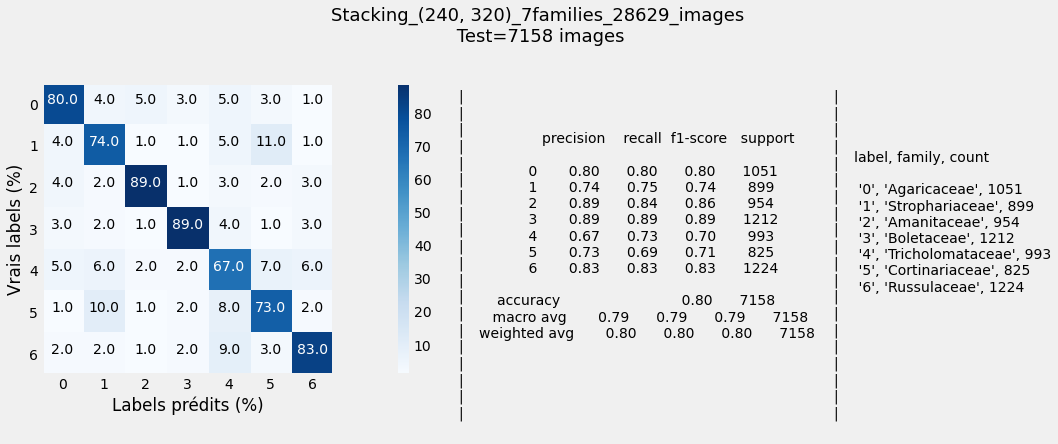

time: 811 ms (started: 2022-02-21 10:24:30 +00:00)


In [51]:
#assess 
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, stack_test_pred_class))
# save report
report = metrics.classification_report(y_test_class, stack_test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_Stacking_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = 'Stacking' + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , stack_test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  'Stacking_model_conf_matrix.jpeg' ,bbox_inches = 'tight')